# **Music Recommendation System**

## Flow


1.  Explore the data
2.  Popularity Based Model
3.  Collaborative Training (Advanced Linear Regression)
4.  Obtain user and song characteristic feature vectors
5.  Clustered Song Recommendation (K-means)
6.  Clustered User Recommendation (FCM)
7.  Comparision in above all model using evaluation metric


In [1]:
import numpy as np
import pandas as pd
from PIL import Image  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def show_image(path,title,a,b):
  img = mpimg.imread(path)
  fig=plt.figure(figsize=(a,b))
  imgplot = plt.imshow(img)
  plt.title(title)
  plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lets store our actual data in Y and R variables

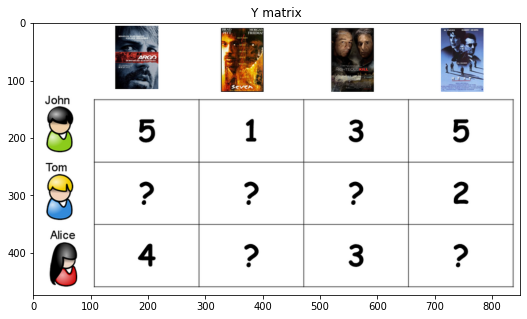

In [4]:
show_image("/content/drive/My Drive/Recommendation System Project/Y.png","Y matrix",10,5)  

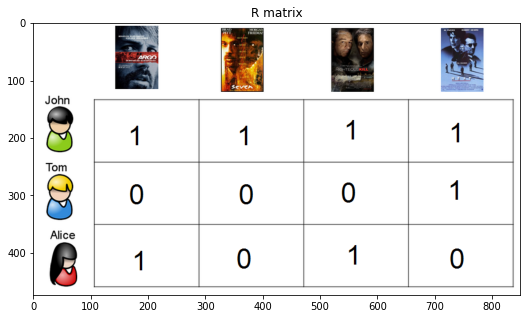

In [5]:
show_image("/content/drive/My Drive/Recommendation System Project/R.png","R matrix",10,5)  

## Extract the raw data from drive

In [6]:
track_metadata_df = pd.read_csv('/content/drive/My Drive/Recommendation System Project/song_data.csv')
count_play_df = pd.read_csv('/content/drive/My Drive/Recommendation System Project/10000.txt', sep='\t', header=None, names=['user','song','play_count'])

print('First see of track metadata:')
print('Number of rows:', track_metadata_df.shape[0])
print('Number of unique songs:', len(track_metadata_df.song_id.unique()))
display(track_metadata_df.head())
print('Note the problem with repeated track metadata. Let\'s see of counts play song by users:')
display(count_play_df.shape, count_play_df.head())

First see of track metadata:
Number of rows: 1000000
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


Note the problem with repeated track metadata. Let's see of counts play song by users:


(2000000, 3)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [7]:
# THERE ARE SOME OUTLIERS ALSO LIKE HERE A USER HEARD A SINGLE SONG 2213 TIMES
# WE WILL REMOVE THAT ALSO IN UPCOMING CODE
# print(np.argmax(count_play_df["play_count"]))
count_play_df["play_count"][1228366]

2213

In [8]:
print(count_play_df) # User Id , play_counts

                                             user  ... play_count
0        b80344d063b5ccb3212f76538f3d9e43d87dca9e  ...          1
1        b80344d063b5ccb3212f76538f3d9e43d87dca9e  ...          2
2        b80344d063b5ccb3212f76538f3d9e43d87dca9e  ...          1
3        b80344d063b5ccb3212f76538f3d9e43d87dca9e  ...          1
4        b80344d063b5ccb3212f76538f3d9e43d87dca9e  ...          1
...                                           ...  ...        ...
1999995  d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92  ...          2
1999996  d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92  ...          4
1999997  d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92  ...          3
1999998  d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92  ...          1
1999999  d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92  ...          1

[2000000 rows x 3 columns]


In [9]:
# DUE TO LACK OF RESOURSES WE ONLY TOOK FIRST 100000 RAW DATA
user=count_play_df["user"][:100000]
song=count_play_df["song"][:100000]
count=count_play_df["play_count"][:100000]
print(user.shape)
print(song.shape)
print(count.shape)

(100000,)
(100000,)
(100000,)


In [10]:
# THERE WILL BE MANY SONGS AND USERS REPEATED IN 100000 RAW DATA THUS WE WILL 
# MAKE A UNIQUE SONG AND USER LIST AND MAP THEM WITH THERE UNIQUE IDs
user_to_id={u:i for i,u in enumerate(user.unique())}
song_to_id={s:i for i,s in enumerate(song.unique())}
id_to_user={i:u for i,u in enumerate(user.unique())}
id_to_song={i:s for i,s in enumerate(song.unique())}
print(len(user_to_id)) # total unique users
print(len(song_to_id)) # total unique songs
print(len(id_to_user))
print(len(id_to_song))

3863
9938
3863
9938


In [11]:
print(id_to_user[50],user_to_id[id_to_user[50]]) # to verify mapping is done correctly

6f62f1c30b0f4b87db28c101ddcab89b4f5d7298 50


In [12]:
# INITIALIZE OUR Y AND R MATRIX WITH ZEROs
import numpy as np
Y=np.zeros((len(user_to_id),len(song_to_id)))
R=np.zeros((len(user_to_id),len(song_to_id)))
print(Y.shape)
print(R.shape)

(3863, 9938)
(3863, 9938)


In [13]:
# FILL THE Y AND R MATRIX ACCORDING TO THE RAW DATA
counter=0
for u,s,c in zip(user,song,count):
  Y[user_to_id[u],song_to_id[s]]=c
  R[user_to_id[u],song_to_id[s]]=1
  counter+=1
print(counter)

100000


In [14]:
print(Y.shape)
print(R.shape)
print(np.sum(Y))

(3863, 9938)
(3863, 9938)
300974.0


In [15]:
# we could also set limits on Y values as 50 because listen count more than 50 for particular song is unusual
Y=np.clip(Y,0,50) # clips the all the Y values above 50
print(Y)
print(R)

[[ 1.  2.  1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. 23. 20.]
 [ 0.  0.  0. ...  0.  0.  0.]]
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


# Lets create Training and Testing Set ( 95 - 5 )

In [16]:
def sparse(m,n,percent):
  #m, n = 20, 10
  np.random.seed(0)
  X = np.random.random((m, n)) < (percent/100)
  return X.astype(int)

In [17]:
# How sparse matrix with 20 percent data looks
print(np.sum(sparse(10,10,20)))
print((sparse(10,10,20)))

25
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [1 1 0 1 1 0 0 1 0 1]
 [0 0 0 0 0 1 0 1 0 1]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 1 0 0 1 0 1 0 1]]


Y matrix is the matrix we are trying to predict, thus we learn using this Y variable. As Y is a matrix thus to create a training and testing data we randomly extract 10 percent data from Y matrix using a 10 percent sparse matrix



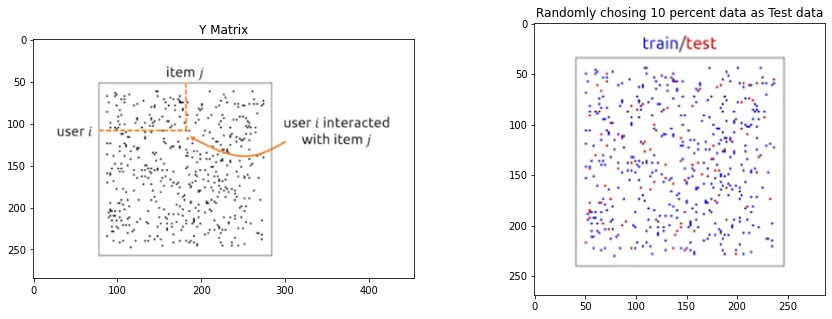

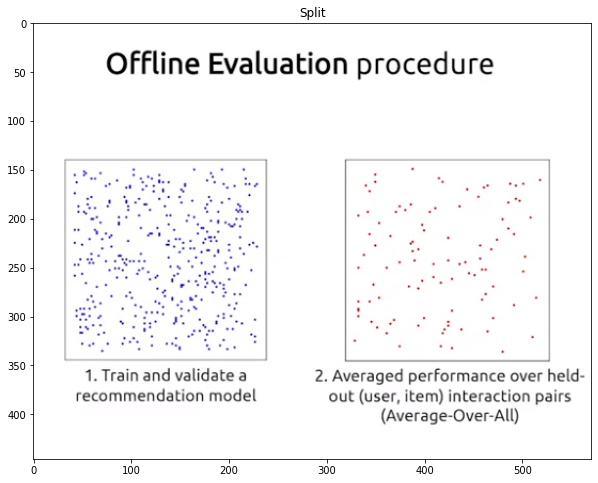

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5)) # row , column
ax1.imshow(mpimg.imread("/content/drive/My Drive/Recommendation System Project/Y5.png"))
ax1.set_title("Y Matrix")
ax2.imshow(mpimg.imread("/content/drive/My Drive/Recommendation System Project/train_test.png"))
ax2.set_title("Randomly chosing 10 percent data as Test data")
plt.show()
show_image("/content/drive/My Drive/Recommendation System Project/split.png","Split",10,15)  

In [19]:
sp=sparse(R.shape[0],R.shape[1],5)
print(np.sum(sp*R)/np.sum(R)*100) # show what percent of actual data gone for testing should be nearly 5

Y_test=Y*sp*R
R_test=R*sp

sp_inv = (sp==0).astype(int) # inverted sparse matrix to choose all other values other than what gone for testing purpose (4.913 %)
Y=Y*sp_inv*R # Y train
R=R*sp_inv # R train

4.913


In [20]:
# calc mean and number of user listened to particular song
# Y is listen count matrix and R is matrix of data availability thus
# Y*R gives only those data point which have 1 in R matrix
mean=np.sum(Y*R,axis=0,keepdims=True)/(np.sum(R,axis=0,keepdims=True)+0.0001)
print(mean.shape)
print(mean)
#sd=(Y*R).std(axis=0,keepdims=True)
# Y=(Y-mean)*R

(1, 9938)
[[ 2.44441728  9.28558163  2.87754515 ...  1.99980002 22.99770023
  19.9980002 ]]


# Evaluation Metric
here we are using absolute error between Y and Y_pred as evaluation metric

In [21]:
def evaluation(Y,Y_pred,R):
  return np.sum(np.abs(Y-Y_pred))/np.sum(R)

In [22]:
pqr=np.array([[1,2,3]])
print(pqr.shape)
print(np.repeat(pqr, repeats = 2, axis = 0))

(1, 3)
[[1 2 3]
 [1 2 3]]


In [23]:
xyz=np.array([[4,5,1],[1,8,3]])
print(xyz)
print(xyz.argsort(axis=1))
print(xyz)

[[4 5 1]
 [1 8 3]]
[[2 0 1]
 [0 2 1]]
[[4 5 1]
 [1 8 3]]


# Popularity Based Recommendation
*   if a user like a song, then he/she will listen thrice or more may be
*   if a user dont like a song, then he/she must have listen it once
*   if a user haven't heard a song then Y matrix value would be 0

In [24]:
# In popularity based we recommend based on maximum average rating
# There are outliers like may be a song is heard 100 times by 2 user that may create a outlier in mean count (mean_count = 200/2 => 100)
# Thus we will only trust those data which has more user support i.e more users had heard that song earlier

count_threshold = 50 
active_user = np.sum(R,axis=0)
H = (active_user>count_threshold) * mean[0] # H is the mean listen count of songs

# So we just copy the mean data for all users to get Y_pred matrix
Y_pred=np.repeat(np.reshape(H,(1,len(H))), repeats = R.shape[0], axis = 0)
print(Y_pred.shape)

(3863, 9938)


In [25]:
print(np.argsort(H)[::-1]) # top hits with most average counts (achieved by sorting mean in descending order)
print(Y_pred[2][91]) # 91 88 1527 1919  104 

[  91   88 1527 ... 6622 6621    0]
7.611839601368553


In [26]:
print(np.max(H)) # max average count

7.611839601368553


## Lets see how the mean data is distributed

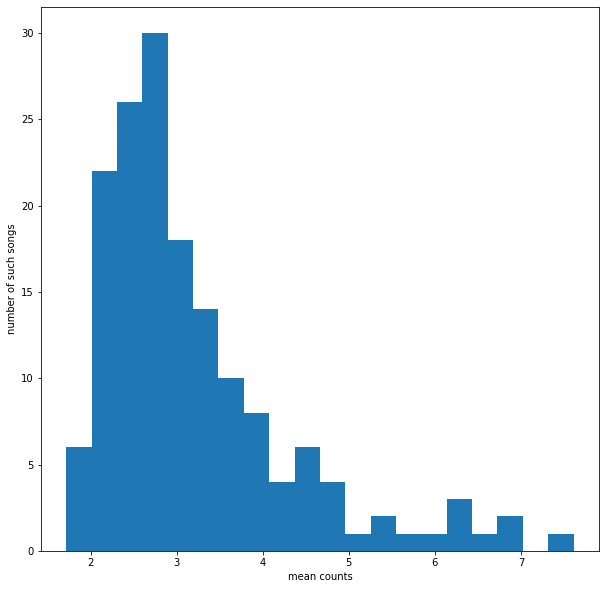

In [27]:
threshold=0.5 # to remove the very less heard songs to see the graph clearly beacuse many songs have not been heard yet and hence have value = 0
H =[a for a in H if a>threshold]
# Generate a normal distribution, center at x=0 and y=5
fig = plt.figure(figsize = (10,10))
# We can set the number of bins with the `bins` kwarg
plt.hist(H,bins=20)
plt.xlabel("mean counts")
plt.ylabel("number of such songs")
plt.show()

## Import the meta data of each song to interact easily while recommendation

In [28]:
import numpy as np

import csv
with open('/content/drive/My Drive/Recommendation System Project/meta.csv') as file:
  csvreader=csv.reader(file)
  fields=next(csvreader)
  fields=next(csvreader)
  x=[]
  for row in csvreader:
    x.append(row[2:])

song_data=np.array(x)
print(song_data.shape)
print(song_data)

(9938, 5)
[['SOAKIMP12A8C130995' 'The Cove' 'Thicker Than Water' 'Jack Johnson' '0']
 ['SOBBMDR12A8C13253B' 'Entre Dos Aguas' 'Flamenco Para Niños'
  'Paco De Lucia' '1976']
 ['SOBXHDL12A81C204C0' 'Stronger' 'Graduation' 'Kanye West' '2007']
 ...
 ['SOGCHYZ12AF72A69EC' 'That Tree (feat. Kid Cudi)'
  'That Tree Featuring Kid Cudi' 'Snoop Dogg featuring Kid Cudi' '2010']
 ['SOOAAQL12B0B80B6D1' 'Borders' 'Dreams' 'The Whitest Boy Alive' '2006']
 ['SOSSZPW12A8C13843D' 'Figures' 'Dreams' 'The Whitest Boy Alive' '2006']]


In [29]:
# recommendation for particular user
def recommend_me(Y_pred,R,user_id):
  ind=(Y_pred[user_id] * (R[user_id]==0)).argsort() # R[user id] == 0 means only those songs that not been heard by that user yet
  ind=ind[::-1][:15] # select top 15 songs
  #print(ind)
  print("Recommendations for user",user_id ,"are :")
  print()
  for i in ind:
    print(song_data[i][1]+" by "+song_data[i][3])
  print("-------------------------------------------------------")

In [30]:
# POPULARITY BASED RECOMMENDATION , IT TELLS YOU THE MOST HIT SONGS
recommend_me(Y_pred,R,57) # user id 57

Recommendations for user 57 are :

You're The One by Dwight Yoakam
Undo by Björk
Frisch und g'sund by Die Mooskirchner
Luvstruck by Southside Spinners
Make Love To Your Mind by Bill Withers
Revelry by Kings Of Leon
Invalid by Tub Ring
Canada by Five Iron Frenzy
Better To Reign In Hell by Cradle Of Filth
Catch You Baby (Steve Pitron & Max Sanna Radio Edit) by Lonnie Gordon
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) by Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner
Almaz by Randy Crawford
Ain't Misbehavin by Sam Cooke
Unite (2009 Digital Remaster) by Beastie Boys
A Beggar On A Beach Of Gold by Mike And The Mechanics
-------------------------------------------------------


In [31]:
print("metric (popularity based)= ",evaluation(Y_test*R_test,Y_pred*R_test,R_test))
# metric tells you that our recommendations has a average offset of nearly 2.85 from actual data

metric (popularity based)=  2.850476359525316


# Collaborative Filtering

In [32]:
# normalize
Y=(Y-mean)*R

In [33]:
n=5 # number of features , dimensions

In [34]:
# Because collaborative filtering is advanced form of regression, and we are also 
# going to train the weight matrix user, song using gradient descent thus
# we initiallize it using random values for now
user=np.random.randn(n,Y.shape[0])
song=np.random.randn(n,Y.shape[1])
print(user.shape)
print(song.shape)

(5, 3863)
(5, 9938)


## Training

In [35]:
err=[]
lr=0.001 # learning rate , obtained after many experimentations
lam=7  # regularization const , obtained after many experimentations
for k in range(200):
  Rating=user.T @ song
  A=(Rating-Y)*R
  J=np.sum(A**2) + lam*np.sum(user**2) + lam*np.sum(song**2)
  err.append(J)
  user = user - lr*( (A @ song.T).T + lam*user )
  song = song - lr*( user @ A + lam*song )
  print(k,end="-->")

0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->25-->26-->27-->28-->29-->30-->31-->32-->33-->34-->35-->36-->37-->38-->39-->40-->41-->42-->43-->44-->45-->46-->47-->48-->49-->50-->51-->52-->53-->54-->55-->56-->57-->58-->59-->60-->61-->62-->63-->64-->65-->66-->67-->68-->69-->70-->71-->72-->73-->74-->75-->76-->77-->78-->79-->80-->81-->82-->83-->84-->85-->86-->87-->88-->89-->90-->91-->92-->93-->94-->95-->96-->97-->98-->99-->100-->101-->102-->103-->104-->105-->106-->107-->108-->109-->110-->111-->112-->113-->114-->115-->116-->117-->118-->119-->120-->121-->122-->123-->124-->125-->126-->127-->128-->129-->130-->131-->132-->133-->134-->135-->136-->137-->138-->139-->140-->141-->142-->143-->144-->145-->146-->147-->148-->149-->150-->151-->152-->153-->154-->155-->156-->157-->158-->159-->160-->161-->162-->163-->164-->165-->166-->167-->168-->169-->170-->171-->172-->173-->174-->175-->176-->177-->178-->179-->180-->181-->182-->183-->184-->

In [36]:
# def sol(lr,lam):
#   #err=[]
#   user=np.random.randn(n,Y.shape[0])
#   song=np.random.randn(n,Y.shape[1])
#   for k in range(300):
#     Rating=user.T @ song
#     A=(Rating-Y)*R
#     #J=np.sum(A**2) + lam*np.sum(user**2) + lam*np.sum(song**2)
#     #err.append(J)
#     user = user - lr*( (A @ song.T).T + lam*user )
#     song = song - lr*( user @ A + lam*song )
#   Y_pred = user.T @ song + mean
#   print(lr,lam,evaluation(Y_test*R_test,Y_pred*R_test))

In [37]:
# for lr in [0.001,0.0005,0.0001,0.00005]:
#   for lam in [5,10,20,30,40,50,60]:
#     sol(lr,lam)

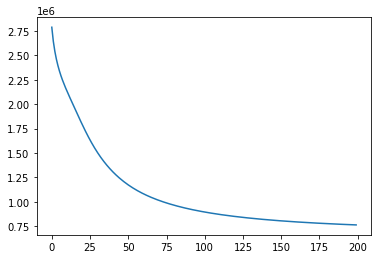

In [38]:
import matplotlib.pyplot as plt
plt.plot(err)

In [39]:
Y_pred = user.T @ song + mean

In [40]:
# print("metric (collaborative, similarity based)= ",evaluation(Y_test*R_test,Y_pred*R_test,R_test))

In [41]:
user=user.T
song=song.T

In [42]:
#np.savetxt("/content/drive/My Drive/Recommendation System Project/user_feature1.csv", user, delimiter=",")

In [43]:
#np.savetxt("/content/drive/My Drive/Recommendation System Project/song_feature1.csv", song, delimiter=",")

# Recommendation



## Recollect the song features from drive

In [44]:
import numpy as np

# write your code here
import csv
with open('/content/drive/My Drive/Recommendation System Project/song_feature.csv') as file:
  csvreader=csv.reader(file)
  # fields=next(csvreader)
  x=[]
  for row in csvreader:
    x.append(list(map(float,row)))

song=np.array(x)
print(song.shape)
print(song)

(9938, 5)
[[-0.26223832 -0.57915429  0.1681672  -0.02099148  0.4289463 ]
 [ 1.18749093  0.8382921   6.7238765  -0.9119011   1.11066879]
 [ 1.49687383 -1.06554503  0.3335669  -1.3569191  -0.53465016]
 ...
 [-0.4028443  -0.47656519  0.46963926  0.81699222  0.06095219]
 [ 0.13952206 -0.2022439  -0.10495276  0.42588791 -0.36766231]
 [-0.41901508  0.61610373 -0.37797701  0.31844266  0.84502606]]


## Recollect the user features from drive

In [45]:
import numpy as np

# write your code here
import csv
with open('/content/drive/My Drive/Recommendation System Project/user_feature.csv') as file:
  csvreader=csv.reader(file)
  # fields=next(csvreader)
  x=[]
  for row in csvreader:
    x.append(list(map(float,row)))

user=np.array(x)
print(user.shape)
print(user)

(3863, 5)
[[-0.07348827  0.42377362 -0.82585587  0.01604815 -0.66324186]
 [ 0.4583801  -0.71635577  0.09320219  0.10502418 -0.21760155]
 [ 0.31978485 -0.50564458 -0.29547927 -0.14934256 -0.06687574]
 ...
 [-0.18412271 -0.51409971  1.19521589 -0.30896705 -0.47222741]
 [ 4.18502095 -3.18030079 -2.80027719  0.11803892  3.46951388]
 [-0.03609517  1.17449852  0.79185111  0.15742693 -0.90067932]]


Calculate Y_pred using user and song feature vectors obtained after training


In [46]:
# prediction
Y_pred = user @ song.T + mean
print(Y_pred.shape)

(3863, 9938)


In [47]:
print("metric (collaborative)= ",evaluation(Y_test*R_test,Y_pred*R_test,R_test))
# metric tells you that our recommendations has a average offset of nearly 1.93 from actual data
# better than popularity method which had a value of 2.8

metric (collaborative)=  1.9312565808243816


# Lets formulate all the recommendations possible

In [48]:
def projection(vector_1,vector_2):
  unit_vector_1 = vector_1 / np. linalg. norm(vector_1)
  unit_vector_2 = vector_2 / np. linalg. norm(vector_2)
  dot_product = np. dot(unit_vector_1, unit_vector_2)
  return dot_product

Recommends based on current song

In [49]:
def recommend_me_similar(n):
  arr=[]
  for i in range(len(song)):
    arr.append(projection(song[n],song[i]))
  arr=np.array(arr)
  ind = arr.argsort()[::-1][:5]
  print("Recommended songs for "+song_data[n][1]+" by "+song_data[n][3] + " are :")
  print()
  for i in ind[1:]:
    print(song_data[i][1]+" by "+song_data[i][3])
  print("-------------------------------------------------------")

Gives the list of similar user, we can use similar user song likings as recommendation to the current user

In [50]:
def autogenerate_playlist(n):
  arr=[]
  for i in range(len(user)):
    arr.append(projection(user[n],user[i]))
  arr=np.array(arr)
  ind = arr.argsort()[::-1][:5]
  print("user" , n ,"has taste similar to")
  print()
  for i in ind[1:]:
    print("user ",i)
  print("above any user playlist could be recommended to user",n)
  print("-------------------------------------------------------")

Recommendation based on last 4 songs

In [51]:
def recommend_me_based_on_last_4_songs(a,b,c,d):
  arr=[]
  vector_1=song[a]
  vector_2=song[b]
  vector_3=song[c]
  vector_4=song[d]
  unit_vector_1 = vector_1 / np. linalg. norm(vector_1)
  unit_vector_2 = vector_2 / np. linalg. norm(vector_2)
  unit_vector_3 = vector_3 / np. linalg. norm(vector_3)
  unit_vector_4 = vector_4 / np. linalg. norm(vector_4)
  vec = 0.4*unit_vector_1 + 0.3*unit_vector_2 + 0.2*unit_vector_3 + 0.1*unit_vector_4
  for i in range(len(song)):
    arr.append(projection(vec,song[i]))
  arr=np.array(arr)
  ind = arr.argsort()[::-1][:5]
  print("Recommendation based on last following played songs are ")
  for k in [a,b,c,d]:
    print(song_data[k][1]+" by "+song_data[k][3])
  print()
  for i in ind:
    print(song_data[i][1]+" by "+song_data[i][3])
  print("-------------------------------------------------------")

In [52]:
# recommend me takek Y_pred,user id as input and tells which songs is most likely to be heard by user based on Y pred[user id] value
# 45 is the user id
recommend_me(Y_pred,R,45) # recommends the popular songs according to your taste or user profile

Recommendations for user 45 are :

Move Shake Drop Remix by DJ Laz
The Good Fight by Dashboard Confessional
Pero Me Acuerdo De Tí by Christina Aguilera
MIC (Speak Life Album Version) by Sev Statik
Prelude/Prologue by Kate Bush
Jumpin'_ Jumpin' by Destiny's Child
Love And Only Love (1991 Live LP Version) by Neil Young
Sol de invierno by Extremoduro
Bodies by Drowning Pool
Smooth Sailing Remix by Method Man / Ghostface Killah / Solomon Childs / Streetlife
Mudanca De Tempo by O Terco
Skyway Avenue by We The Kings
The Boy Does Nothing by Alesha Dixon
Long Arm Of The Law by Looptroop
Quutamo by Apocalyptica
-------------------------------------------------------


In [53]:
# 12 is the current song id
recommend_me_similar(12)  #345 #12 #119 # Recommends songs based on current song

Recommended songs for Love Shack by The B-52's are :

What They Found by Octopus Project
She Bangs The Drums by The Stone Roses
Pata Pata (Album Version) by Miriam Makeba
Slow Death by Flamin' Groovies
-------------------------------------------------------


In [54]:
# 45 is the user id
autogenerate_playlist(45) # gives list of similar taste users

user 45 has taste similar to

user  1296
user  1400
user  3263
user  1673
above any user playlist could be recommended to user 45
-------------------------------------------------------


In [55]:
# 123 --> 429 --> 660 --> 12 are the song ids of last 4 songs played
recommend_me_based_on_last_4_songs(12,660,429,123) # recommendation based on last 4 songs

Recommendation based on last following played songs are 
Love Shack by The B-52's
Street Justice by MSTRKRFT
Angel Echoes by Four Tet
Tell Me Why by Supermode

Lex by Ratatat
Sleeping Lessons (Album) by The Shins
Out Of Sight by Smash Mouth
All She Wants Is by Duran Duran
Someone's Missing by MGMT
-------------------------------------------------------


# Lets Visualize the song and user feature vectors

### Clustering Algorithms

In [56]:
# k-means

def K_means_clustering(data,K,itr,eps):
  # random initialization of clusters
  # write your code here
  def random_points(data,K):
    return np.random.choice(len(data),K)
  init=random_points(data,K)
  center=[]
  for i in init:
    center.append(data[i])
  center=np.array(center)
  #print(center)

  def calc_group(x,center):
    err=0
    group=[[] for _ in range(len(center))]
    for xi in x:
      dist=[]
      for c in center:
        dist.append(np.linalg.norm(xi-c))
      index=dist.index(min(dist))
      err+=min(dist)
      group[index].append(xi)
    return group,err/len(x)

  def label(x,center):
    label=[]
    for a in x:
      dist=[]
      for c in center:
        dist.append(np.linalg.norm(a-c))
      label.append(dist.index(min(dist)))
    return np.array(label)

  def calc_center(group):
    center=[]
    for g in group:
      center.append(np.mean(np.array(g),axis=0))
    return np.array(center)
  err=[]
  for n in range(itr):
    # assignment stage
    # write your code here
    group,error=calc_group(data,center)
    err.append(error)
    # re-estimation stage
    # write your code here
    center=calc_center(group) 
    #print(Cents)
    if n>2:
        if abs(err[n]-err[n-1])<eps:
          break

    print(n,end = '-->')
   
  return group, center,err,label(data,center)


In [57]:
# Fuzzy C Means

def FCM(data,K,itr,eps):
  U=np.random.rand(len(data),K)
  U=U/np.sum(U,axis=1,keepdims=True)
  J=[]
  for n in range(itr):

    r=1.05
    m=[]
    for i in range(data.shape[1]):
      m.append(np.sum((U**r)*data[:,i].reshape(len(data),1),axis=0,keepdims=True)/np.sum((U**r),axis=0,keepdims=True))
    center=np.concatenate(m,axis=0).T

    cluster_label=np.argmax(U,axis=1) #Label Points
    # plt.figure()
    # for l in range(K):
    #   id=np.where(cluster_label==l)
    #   plt.plot(data[id,0],data[id,1],'.',color=clr[l],marker=mrk[l])
    # Cents=center
    # plt.plot(Cents[:,0],Cents[:,1],'X',color='k')
    # plt.title('Iteration= %d' % (i))

    D=[]
    for c in center:
      d=np.linalg.norm(data-c,axis=1,keepdims=True)
      if len(D)==0:
        D=d
      else:
        D=np.concatenate((D,d),axis=1)
    J.append(np.sum(U**r * D))

    U=np.zeros(U.shape)
    for i in range(K):
      U+=((D**2)/(D**2)[:,i].reshape(len(data),1))**(1/(r-1))
    U=1/U
    print(n,end = '-->')
  # plt.figure()
  # plt.plot(J)
  return U,center,J

## Visualization of Song Feature Vectors

In [58]:
# Denormalize
Y = (Y + mean)*R
print(Y)

[[ 1.  2.  1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. 23. 20.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [59]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(song)
print(tsne_results.shape)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9938 samples in 0.008s...
[t-SNE] Computed neighbors for 9938 samples in 0.823s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9938
[t-SNE] Computed conditional probabilities for sample 2000 / 9938
[t-SNE] Computed conditional probabilities for sample 3000 / 9938
[t-SNE] Computed conditional probabilities for sample 4000 / 9938
[t-SNE] Computed conditional probabilities for sample 5000 / 9938
[t-SNE] Computed conditional probabilities for sample 6000 / 9938
[t-SNE] Computed conditional probabilities for sample 7000 / 9938
[t-SNE] Computed conditional probabilities for sample 8000 / 9938
[t-SNE] Computed conditional probabilities for sample 9000 / 9938
[t-SNE] Computed conditional probabilities for sample 9938 / 9938
[t-SNE] Mean sigma: 0.219914
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.988373
[t-SNE] KL divergence after 300 iterations: 2.994519
(9938, 3)


In [60]:
_,_,_,labels=K_means_clustering(song,6,25,0)

0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->

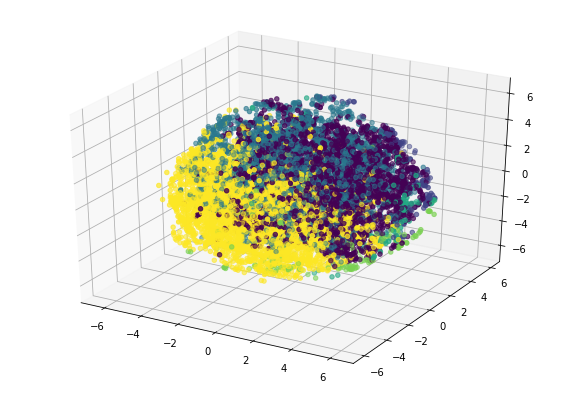

In [61]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.scatter(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2],c=labels)

In [62]:
def songcluster_recommendation(Y,R,labels):
  Y_pred=np.zeros(Y.shape)
  for l in range(max(labels)+1):
    A = np.reshape(labels==l,(1,len(labels)))
    A = np.repeat(A, repeats = R.shape[0], axis = 0)
    mean=np.sum(Y*R*A,axis=1,keepdims=True)/(np.sum(R*A,axis=1,keepdims=True)+0.0001)
    mean=np.repeat(mean, repeats = R.shape[1], axis = 1)
    Y_pred += mean*A
  return Y_pred

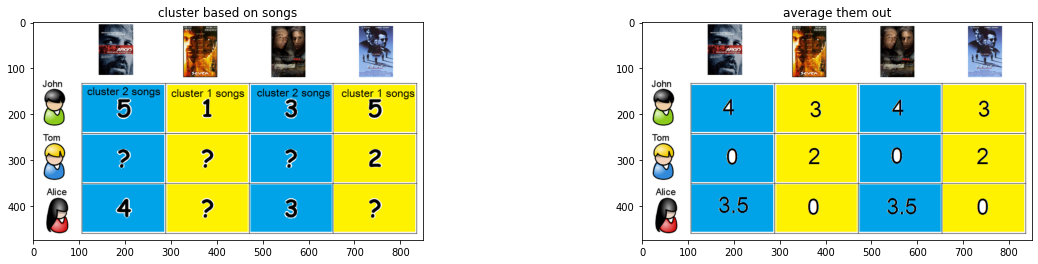

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,4)) # row , column
ax1.imshow(mpimg.imread("/content/drive/My Drive/Recommendation System Project/Y1.png"))
ax1.set_title("cluster based on songs")
ax2.imshow(mpimg.imread("/content/drive/My Drive/Recommendation System Project/Y2.png"))
ax2.set_title("average them out")
plt.show()

In [64]:
Y_pred=songcluster_recommendation(Y,R,np.array(labels))

In [65]:
print("metric (collaborative, songcluster)= ",evaluation(Y_test*R_test,Y_pred*R_test,R_test))
# metric tells you that our recommendations has a average offset of nearly 2 from actual data
# better than popularity method which had a value of 2.8

metric (collaborative, songcluster)=  2.001678361792032


In [66]:
# recommend me takes Y_pred,user id as input and tells which songs is most likely to be heard by user based on Y pred[user id] value
# 45 is the user id
recommend_me(Y_pred,R,45)

Recommendations for user 45 are :

Sky And Sand by Paul & Fritz Kalkbrenner
Walking On The Moon by The Police
Hey Mama by Black Eyed Peas
A Beggar On A Beach Of Gold by Mike And The Mechanics
Flake by Jack Johnson
3AM (LP Version) by matchbox twenty
We Have A Map Of The Piano by Múm
No Surprise by Daughtry
Lacrimosa by Regina Spektor
Bird Song by Florence + The Machine
The Good Fight by Dashboard Confessional
Skyway Avenue by We The Kings
Clint Eastwood (Explicit) by Gorillaz
Buttons by The Pussycat Dolls
It's Not My Time by 3 Doors Down
-------------------------------------------------------


## Lets try DBSCAN
On using DBSCAN , we found many data points on the boundary getting clustered to only one point and rest gets clutered nicely, Thus we clustered those boundary points again using KNN

### Code

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import itertools

In [68]:
class Dbscan:

  def dis(self,x,j,epsilon,group,length,alot):
    l=len(x)
    d=np.sqrt(np.sum((x-x[j])**2,1))
    index=[i for i in range(len(d)) if(d[i]<epsilon and d[i]!=0)]
    m=group
    if (len(index)>=length):
      if (alot[j]==0):
        alot[j]=group
      for i in index :
        if (alot[i]==0):
          alot[i]=alot[j]
        else:
          m=min(m,alot[i])
      if (m<group):
        alot[j]=m
        for i in index: alot[i]=m
      return alot,1
    else:
      return alot,0

  def D_run(self,x,epsilon,length):
    l1=len(x)
    group=1
    alot=np.zeros(l1)
    for j in range(l1):
      alot,s=self.dis(x=x,j=j,epsilon=epsilon,group=group,length=length,alot=alot)
      group+=s
    v=alot
    sset=list(set(v))
    ss={}
    for i in range(len(sset)): ss[sset[i]]=i
    alot=[]
    for i in v:
      alot.append(ss[i])
    return alot

In [69]:
def Recommend_me(position,np_song,extra=0):
  arr={}
  for i in range(len(np_song)):
    arr[i]=np.linalg.norm(position-np_song[i])
  arr={k: v for k, v in sorted(arr.items(), key=lambda item: item[1])}
  out = dict(itertools.islice(arr.items(), 5+extra))
  for i, value in out.items():
    print(song_data[i][1],"   by   ",song_data[i][3])
  print("-------------------------------------------------------")

In [70]:
class reduc:

  def cal_centers(self,data,alot):
    l=len(set(alot))
    c=np.zeros(l)
    m,n=data.shape # assuming rank >=2
    z=np.zeros((l,n))
    for i in range(m):
      z[alot[i]]+=data[i]
      c[alot[i]]+=1
    for i in range(l):
      z[i]/=c[i]
    return z[1:,:]

  def mean_clus(self,data,alot):
    z=self.cal_centers(data,alot)
    for i in range(len(data)):
      if (alot[i]==0):
        c=np.sqrt(np.sum((z-data[i])**2,1))
        c=list(c)
        alot[i]=c.index(min(c[1:]))+1
    return alot

In [71]:
def cluster(alot):
  clusters={}
  for i in range(len(alot)):
    clusters[alot[i]]=clusters.get(alot[i],[])
    clusters[alot[i]].append(i)
  return clusters

In [72]:
def similar_cluster(clusters,data,alot_cluster,index,extra=0):
  focus=clusters[alot_cluster][index]
  close={i:np.linalg.norm(data[focus]-data[i]) for i in clusters[alot_cluster]}
  close={k: v for k, v in sorted(close.items(), key=lambda item: item[1])}
  close = dict(itertools.islice(close.items(), 5+extra))
  for i,j in close.items():
    print(song_data[i][1],"_________",song_data[i][3])

In [73]:
X_embedded2 = TSNE(n_components=2, n_iter=300).fit_transform(song)

### visualization

In [74]:
d=Dbscan()
dbscan_5D=d.D_run(song,0.2,10)
print(set(dbscan_5D))

{0, 1, 2, 3, 4, 5, 6, 7}


In [75]:
r=reduc()
alot=r.mean_clus(song,dbscan_5D)
set(alot)

{1, 2, 3, 4, 5, 6, 7}

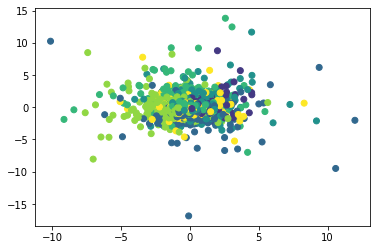

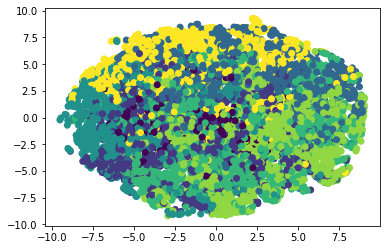

In [76]:
plt.figure()
plt.scatter(song[:,0],song[:,1],c=alot)  
plt.show()

plt.figure()        
plt.scatter(X_embedded2[:,0],X_embedded2[:,1],c=alot)  
plt.show()

In [77]:
cluster_dbscan_redu=cluster(alot)

In [78]:
similar_cluster(cluster_dbscan_redu,song,2,10,extra=5)

Swallowed In The Sea _________ Coldplay
Gatekeeper _________ Feist
Jupiter Approach _________ Digitalism
Satin In A Coffin _________ Modest Mouse
Nights On Broadway (Album Version) _________ Bee Gees
Old Man (Album Version) _________ Neil Young
Hysteric _________ Yeah Yeah Yeahs
She'd Rather Be With Me _________ The Turtles
Twisted Logic _________ Coldplay
Easy girls (acoustic clubbing) _________ Les Négresses Vertes


In [79]:
similar_cluster(cluster_dbscan_redu,song,4,10,extra=0)

It's My Party _________ Lesley Gore
The Day and the Time (featuring Gustavo Cerati) _________ Shakira
The Cut _________ Benga
Bonnie And Clyde _________ Brigitte Bardot / Serge Gainsbourg
The Pretender _________ Foo Fighters


In [80]:
Y_pred=songcluster_recommendation(Y,R,np.array(alot))

In [81]:
print("metric (collaborative, songcluster)= ",evaluation(Y_test*R_test,Y_pred*R_test,R_test))
# metric tells you that our recommendations has a average offset of nearly 2 from actual data
# better than popularity method which had a value of 2.8

metric (collaborative, songcluster)=  2.151145359134438


In [82]:
# recommend me takes Y_pred,user id as input and tells which songs is most likely to be heard by user based on Y pred[user id] value
# 45 is the user id
recommend_me(Y_pred,R,45)

Recommendations for user 45 are :

Gente by Laura Pausini
Novocaine by Kalafut
Mondegreen by Yeasayer
The Way She Dances by N.E.R.D.
Money (featuring Gary "Nesta" Pine & Dollarman) by Easy Star All-Stars
Is This It by The Strokes
Knife Prty (LP Version) by Deftones
Rx Queen (LP Version) by Deftones
Deliverance by Bubba Sparxxx
Spiderwebs by No Doubt
In Our Nature by José González
Get Like Me by David Banner / Chris Brown / Yung Joc
Streets On Fire (Explicit Album Version) by Lupe Fiasco
Iron Maiden (Live In Dortmund) by Iron Maiden
Me_ Myself & I by De La Soul
-------------------------------------------------------


## Visualization of User Feature Vectors

In [83]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(user)
print(tsne_results.shape)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3863 samples in 0.004s...
[t-SNE] Computed neighbors for 3863 samples in 0.249s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3863
[t-SNE] Computed conditional probabilities for sample 2000 / 3863
[t-SNE] Computed conditional probabilities for sample 3000 / 3863
[t-SNE] Computed conditional probabilities for sample 3863 / 3863
[t-SNE] Mean sigma: 0.306091
[t-SNE] KL divergence after 50 iterations with early exaggeration: 82.250870
[t-SNE] KL divergence after 300 iterations: 1.697062
(3863, 3)


In [84]:
U,cents,error=FCM(user,7,100,10**(-20))
labels=np.argmax(U,axis=1) #Label Points

0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->25-->26-->27-->28-->29-->30-->31-->32-->33-->34-->35-->36-->37-->38-->39-->40-->41-->42-->43-->44-->45-->46-->47-->48-->49-->50-->51-->52-->53-->54-->55-->56-->57-->58-->59-->60-->61-->62-->63-->64-->65-->66-->67-->68-->69-->70-->71-->72-->73-->74-->75-->76-->77-->78-->79-->80-->81-->82-->83-->84-->85-->86-->87-->88-->89-->90-->91-->92-->93-->94-->95-->96-->97-->98-->99-->

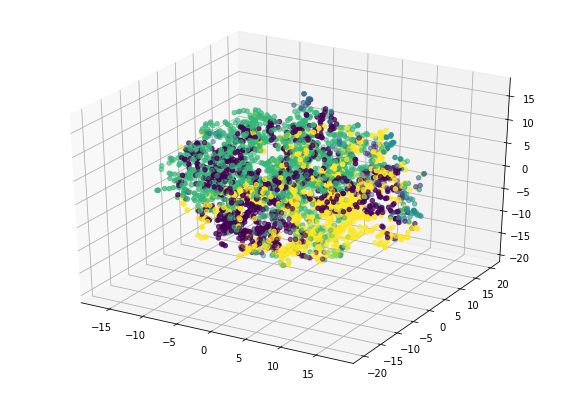

In [85]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
ax.scatter(tsne_results[:,0], tsne_results[:,1],tsne_results[:,2],c=labels)

In [86]:
def usercluster_recommendation(Y,R,labels):
  Y_pred=np.zeros(Y.shape)
  for l in range(max(labels)+1):
    A = np.reshape(labels==l,(len(labels),1))
    A = np.repeat(A, repeats = R.shape[1], axis = 1)
    mean=np.sum(Y*R*A,axis=0,keepdims=True)/(np.sum(R*A,axis=0,keepdims=True)+0.0001)
    mean=np.repeat(mean, repeats = R.shape[0], axis = 0)
    Y_pred += mean*A
  return Y_pred

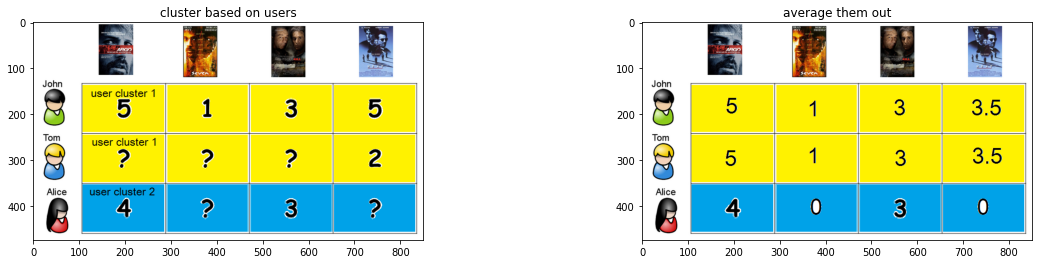

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,4)) # row , column
ax1.imshow(mpimg.imread("/content/drive/My Drive/Recommendation System Project/Y3.png"))
ax1.set_title("cluster based on users")
ax2.imshow(mpimg.imread("/content/drive/My Drive/Recommendation System Project/Y4.png"))
ax2.set_title("average them out")
plt.show()

In [88]:
Y_pred=usercluster_recommendation(Y,R,np.array(labels))

In [89]:
print("metric (collaborative, usercluster)= ",evaluation(Y_test*R_test,Y_pred*R_test,R_test))
# metric tells you that our recommendations has a average offset of nearly 2.5 from actual data
# better than popularity method which had a value of 2.8

metric (collaborative, usercluster)=  2.4503784432663163


In [90]:
# recommend me takes Y_pred,user id as input and tells which songs is most likely to be heard by user based on Y pred[user id] value
# 45 is the user id
recommend_me(Y_pred,R,45)

Recommendations for user 45 are :

The Good Fight by Dashboard Confessional
Long Arm Of The Law by Looptroop
Out Of Sight by Smash Mouth
Spider's Web by Katie Melua
Paperweight by Joshua Radin_ Schuyler Fisk
Smooth Sailing Remix by Method Man / Ghostface Killah / Solomon Childs / Streetlife
Love And Only Love (1991 Live LP Version) by Neil Young
All At Once by Jack Johnson
Salt Water Sound by Zero 7
Swing Life Away (Acoustic) by Rise Against
Fireworks (bonus track) by The Whitest Boy Alive
In League With Satan by Krisiun
Rollin' Through The Sunshine by Trailer Choir_ Trailer Choir
Caravan Of Love by The Housemartins
Get Ready To Bounce Recall 08 by Brooklyn Bounce
-------------------------------------------------------


### Example of user cluster recommendation

In [91]:
P=np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
Q=np.array([[1,1,1,0],[1,1,0,1],[1,0,1,1]])
labels=np.array([0,0,1])
print(P)
print(Q)
print(usercluster_recommendation(P,Q,labels))

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
[[1 1 1 0]
 [1 1 0 1]
 [1 0 1 1]]
[[ 2.99985001  3.99980001  2.99970003  7.99920008]
 [ 2.99985001  3.99980001  2.99970003  7.99920008]
 [ 8.99910009  0.         10.99890011 11.99880012]]


# Evaluation Metric Comparison with a standard

In [97]:
A=["popularity based","collaborative filtering","songclustering model","songclustering(DBSCAN + KNN)","user clustering model"]
B=["Mean Absolute Error"]
C=np.array([2.85,1.93,2.00,2.15,2.45])
import pandas
pandas.DataFrame(C,A,B)

,Mean Absolute Error
popularity based,2.85
collaborative filtering,1.93
songclustering model,2.00
songclustering(DBSCAN + KNN),2.15
user clustering model,2.45


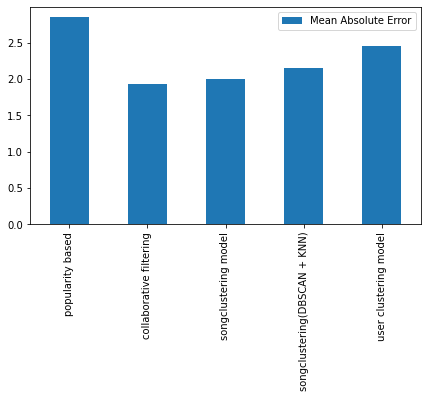

In [98]:
pandas.DataFrame(C,A,B).plot(kind="bar",figsize=(7,4))

In [99]:
def optimize(k):
  _,_,_,labels=K_means_clustering(song,k,25,0)
  Y_pred=songcluster_recommendation(Y,R,np.array(labels))
  return evaluation(Y_test*R_test,Y_pred*R_test,R_test)
arr=[]
for k in range(1,8):
  arr.append(optimize(k))
  print("for k =" ,k," we got MAE=",arr[-1])

0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->for k = 1  we got MAE= 2.1291408608485103
0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->for k = 2  we got MAE= 2.11279226911976
0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->for k = 3  we got MAE= 2.1071354122311843
0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->for k = 4  we got MAE= 2.0765718117565948
0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->for k = 5  we got MAE= 2.0564871354282332
0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->for k = 6  we got MAE= 2.083629554044579
0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->1

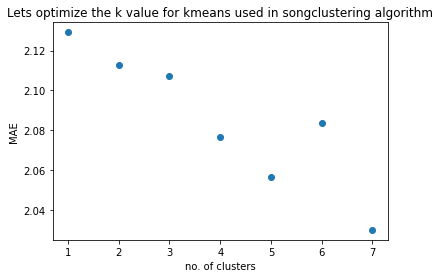

In [100]:
plt.scatter([1,2,3,4,5,6,7],arr)
plt.title("Lets optimize the k value for kmeans used in songclustering algorithm")
plt.xlabel("no. of clusters")
plt.ylabel("MAE")
plt.show()